## Atualizar o python

In [ ]:
import pandas as pd
import os
import ssl

#ssl._create_default_https_context = ssl._create_unverified_context

#url do dataset
url = "https://dados.mg.gov.br/dataset/97908407-bb23-4381-9582-f9bdbc81725a/resource/58cf2019-ce85-4cb0-a732-89747424def5/download/dados_violencia_mulheres_ses_2025.csv"

#pasta 'data'
if not os.path.exists('data'):
    os.makedirs('data')

#DataFrame na pasta 'data'
#index=False evita que o pandas crie uma coluna extra com os números das linhas
#df = pd.read_csv(url, sep=';')
#df.to_csv('data/dados_violencia_mulheres_ses_2025.csv', sep=';', index=False, encoding='utf-8-sig')

print("Sucesso ao salvar na pasta 'data'")
#print(df.head(5))

In [ ]:
df = pd.read_csv('data/dados_violencia_mulheres_ses_2025.csv', sep=';')
df.to_csv('data/dados_violencia_mulheres_ses_2025.csv', sep=';', index=False, encoding='utf-8-sig')
print(df.head(5))

In [39]:
import glob
import unicodedata

#uniao dos arquivos CSV
arquivos = glob.glob('./data/dados_violencia_mulheres_ses_*.csv')
dfs = []

for f in arquivos:
    df_ano = pd.read_csv(f, sep=';', encoding='utf-8-sig')
    df_ano['ano_referencia'] = f.split('_')[-1].split('.')[0]
    dfs.append(df_ano)

df_completo = pd.concat(dfs, ignore_index=True)

#df_completo['dt_notific'] = pd.to_datetime(df_completo['dt_notific'])
#print(df_completo.head(5))

#corrigir idade com virgula
df_completo['nu_idade_n'] = df_completo['nu_idade_n'].astype(str).str.replace(',', '.')
df_completo['nu_idade_n'] = pd.to_numeric(df_completo['nu_idade_n'], errors='coerce')

#limpar texto
def limpar_texto(txt):
    if pd.isna(txt): return "não informado"
    nfkd = unicodedata.normalize('NFKD', str(txt))
    return "".join([c for c in nfkd if not unicodedata.combining(c)]).strip().lower()

colunas_texto = ['cs_sexo', 'cs_raca', 'local_ocor', 'autor_sexo']
for col in colunas_texto:
    if col in df_completo.columns:
        df_completo[col] = df_completo[col].apply(limpar_texto)

#limpeza das colunas
colunas_texto = df_completo.select_dtypes(include=['object']).columns
for col in colunas_texto:
    df_completo[col] = df_completo[col].apply(limpar_texto)

#converter colunas de violência para binario
cols_violencia = ['viol_fisic', 'viol_psico', 'viol_sexu', 'les_autop']
for col in cols_violencia:
    if col in df_completo.columns:
        #garantir que os valores sejam limpos antes da conversão
        df_completo[col] = df_completo[col].apply(limpar_texto)
        df_completo[col] = df_completo[col].map({'sim': 1, 'nao': 0}).fillna(0).astype(int)

#limpar e extrair data
df_completo['dt_notific'] = pd.to_datetime(df_completo['dt_notific'], errors='coerce')
df_completo = df_completo.dropna(subset=['dt_notific'])
df_completo['mes_notific'] = df_completo['dt_notific'].dt.month
df_completo['ano_extraido'] = df_completo['dt_notific'].dt.year #extrair ano da data de notificacao

#para criar faixas etarias
bins = [-1, 12, 18, 25, 45, 60, 120]
labels = ['Criança', 'Adolescente', 'Jovem Adulta', 'Adulta', 'Meia Idade', 'Idosa']
df_completo['faixa_etaria'] = pd.cut(df_completo['nu_idade_n'], bins=bins, labels=labels)

#calculo da severidade da violencia
df_completo['severidade'] = df_completo[['viol_fisic', 'viol_psico', 'viol_sexu']].sum(axis=1)



print(f"Total de registros processados: {len(df_completo)}")
print(df_completo[['nu_idade_n', 'faixa_etaria', 'viol_fisic', 'cs_raca']].head())

Total de registros processados: 131172
   nu_idade_n  faixa_etaria  viol_fisic   cs_raca
0         6.0       Criança           1    branca
1         0.0       Criança           0     parda
2        21.0  Jovem Adulta           1     preta
3        26.0        Adulta           1  ignorado
4        26.0        Adulta           0    branca


In [45]:
pip install pyarrow

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 31.2 MB 3.8 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os

output_dir = './data/silver' #garantir criacao do diretorio
os.makedirs(output_dir, exist_ok=True)

#salvar em formato parquet
try:
    df_completo.to_parquet(f'{output_dir}/violencia_mulheres_2010_2014_limpo.parquet', index=False)
    print("Arquivo salvo com sucesso em formato Parquet (Tipagem preservada)!")
except ImportError:
    print("Instale o pyarrow (pip install pyarrow) para salvar em Parquet.")
    # Fallback para CSV se não conseguir usar parquet (mas lembre-se que perde dtypes)
    df_completo.to_csv(f'{output_dir}/violencia_mulheres_2010_2014_limpo.csv', index=False, sep=';', encoding='utf-8')

#TODO:talvez salvar a tabela agregada(gold) 
#para uso em tabelas sazonais
#exemplo:df_agrupado.to_csv('./data/gold/violencia_por_mes_ano.csv', index=False)

## Analises do conjunto de Dados

Vamos utilizar matplotlib para gerar os kpis

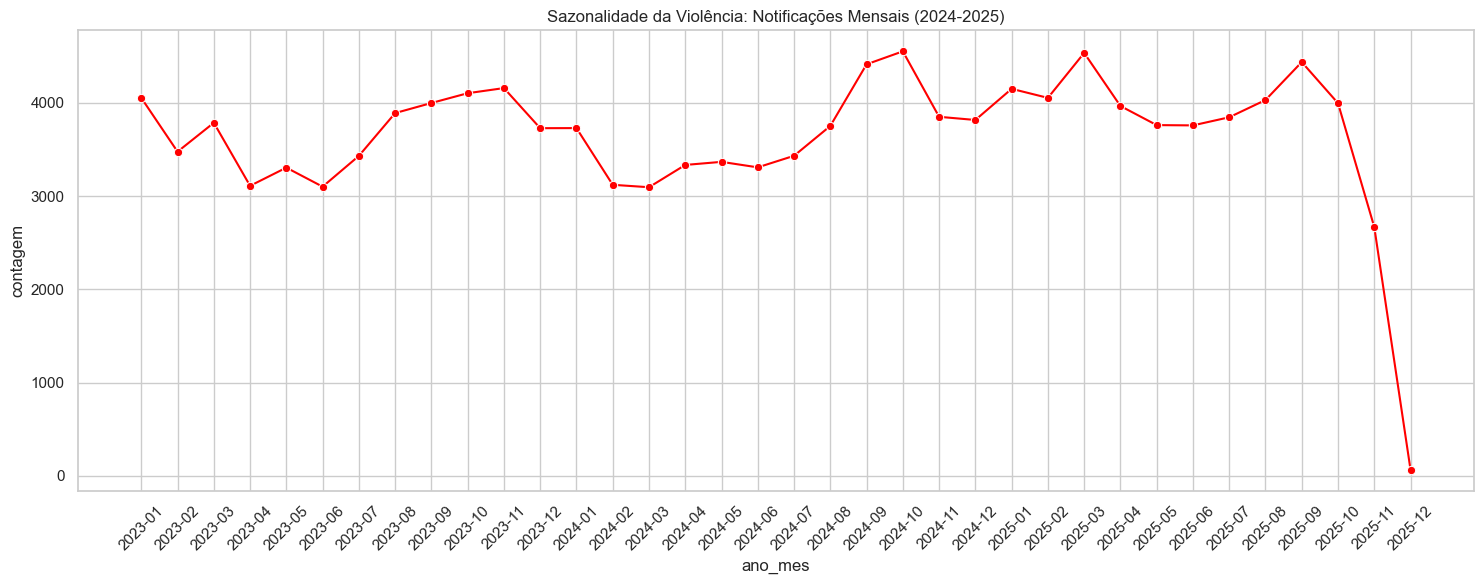

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

#configurando o visual dos graficos
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

# -- Primeira Analise = evolucao anual das notificacoes de violencia contra a mulher --#
df_completo['ano_mes'] = df_completo['dt_notific'].dt.to_period('M').astype(str)

plt.figure(figsize=(15, 6))
df_contagem = df_completo.groupby('ano_mes').size().reset_index(name='contagem')
sns.lineplot(data=df_contagem, x='ano_mes', y='contagem', marker='o', color='red')
plt.xticks(rotation=45)
plt.title('Sazonalidade da Violência: Notificações Mensais (2024-2025)')
plt.tight_layout()
plt.show()


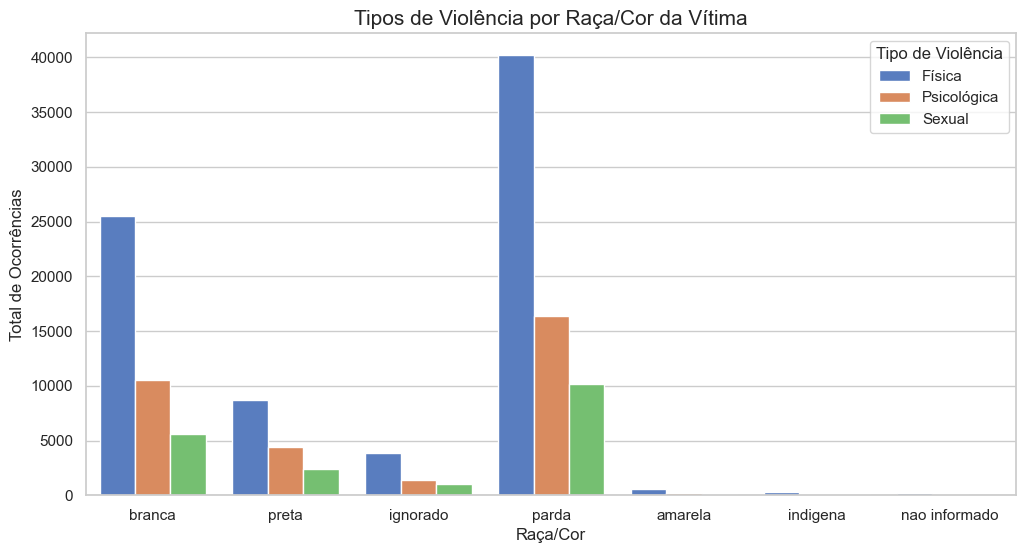

In [41]:
# -- Segunda Analise = tipos de violencia por raca/cor da vitima -- #
df_melt = df_completo.melt(id_vars=['cs_raca'], 
                           value_vars=['viol_fisic', 'viol_psico', 'viol_sexu'],
                           var_name='tipo_violencia', value_name='ocorrencia')

#filtrar onde a ocorrencia é 1 (Sim)
df_melt = df_melt[df_melt['ocorrencia'] == 1]

plt.figure()
sns.countplot(data=df_melt, x='cs_raca', hue='tipo_violencia', palette='muted')
plt.title('Tipos de Violência por Raça/Cor da Vítima', fontsize=15)
plt.xlabel('Raça/Cor')
plt.ylabel('Total de Ocorrências')
plt.legend(title='Tipo de Violência', labels=['Física', 'Psicológica', 'Sexual'])
plt.show()

/var/folders/jq/46shj8rd59v43flwtsw1zc3c0000gn/T/ipykernel_22355/4283051447.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_completo, y='faixa_etaria', order=ordem_idade, palette='magma')


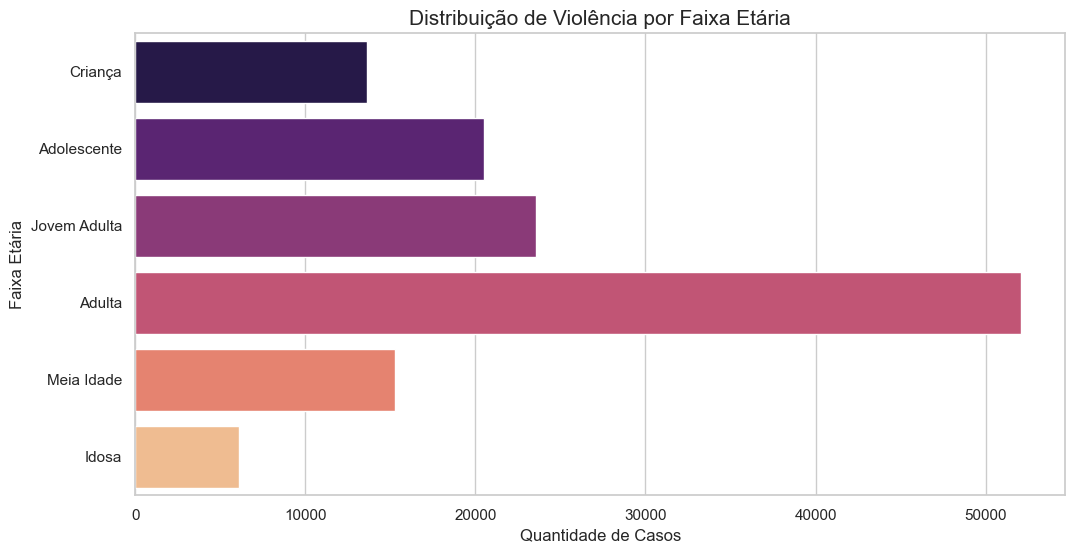

In [42]:
# -- Terceira Analise = faixa etaria das vitimas de violencia -- #
plt.figure()
ordem_idade = ['Criança', 'Adolescente', 'Jovem Adulta', 'Adulta', 'Meia Idade', 'Idosa']
sns.countplot(data=df_completo, y='faixa_etaria', order=ordem_idade, palette='magma')
plt.title('Distribuição de Violência por Faixa Etária', fontsize=15)
plt.xlabel('Quantidade de Casos')
plt.ylabel('Faixa Etária')
plt.show()

/var/folders/jq/46shj8rd59v43flwtsw1zc3c0000gn/T/ipykernel_22355/1300643577.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_tipos, x='Tipo de Violência', y='Total de Casos', palette='Reds_r')


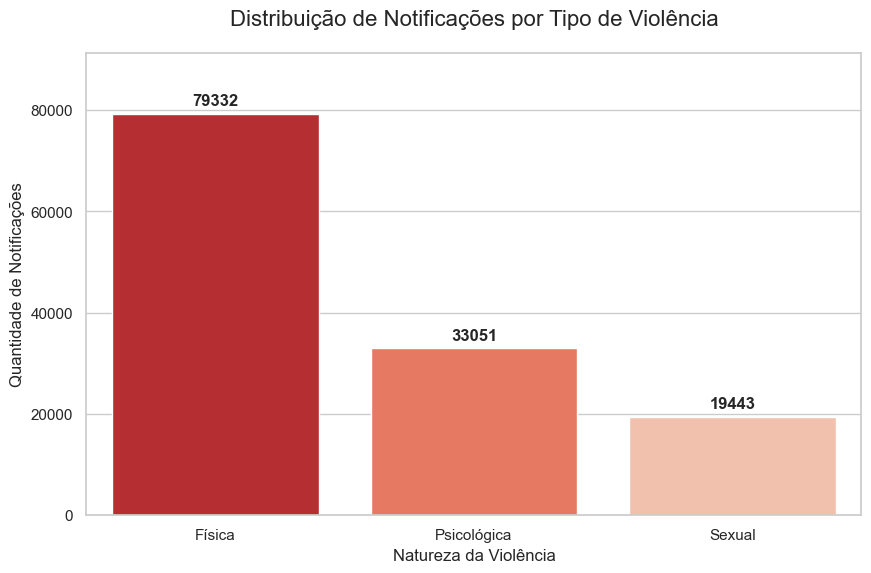

In [43]:
# -- Quarta Analise = tipos de violencia mais comuns -- #
#selecionar apenas as colunas de tipos de violencia
cols_violencia = ['viol_fisic', 'viol_psico', 'viol_sexu']

#somar o total de cada tipo (pela limpeza anterior, os valores são 1 para sim e 0 para nao)
total_por_tipo = df_completo[cols_violencia].sum().sort_values(ascending=False)

#dataframe convertido para facilitar a plotagem
df_tipos = total_por_tipo.reset_index()
df_tipos.columns = ['Tipo de Violência', 'Total de Casos']

#mapear nomes para melhor visualizacao
nomes_formatados = {
    'viol_fisic': 'Física',
    'viol_psico': 'Psicológica',
    'viol_sexu': 'Sexual'
}
df_tipos['Tipo de Violência'] = df_tipos['Tipo de Violência'].map(nomes_formatados)

#visualizacao
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

ax = sns.barplot(data=df_tipos, x='Tipo de Violência', y='Total de Casos', palette='Reds_r')

#numeracao das barras
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize=12, fontweight='bold')

plt.title('Distribuição de Notificações por Tipo de Violência', fontsize=16, pad=20)
plt.ylabel('Quantidade de Notificações')
plt.xlabel('Natureza da Violência')
plt.ylim(0, df_tipos['Total de Casos'].max() * 1.15) # Dá espaço para os labels

plt.show()

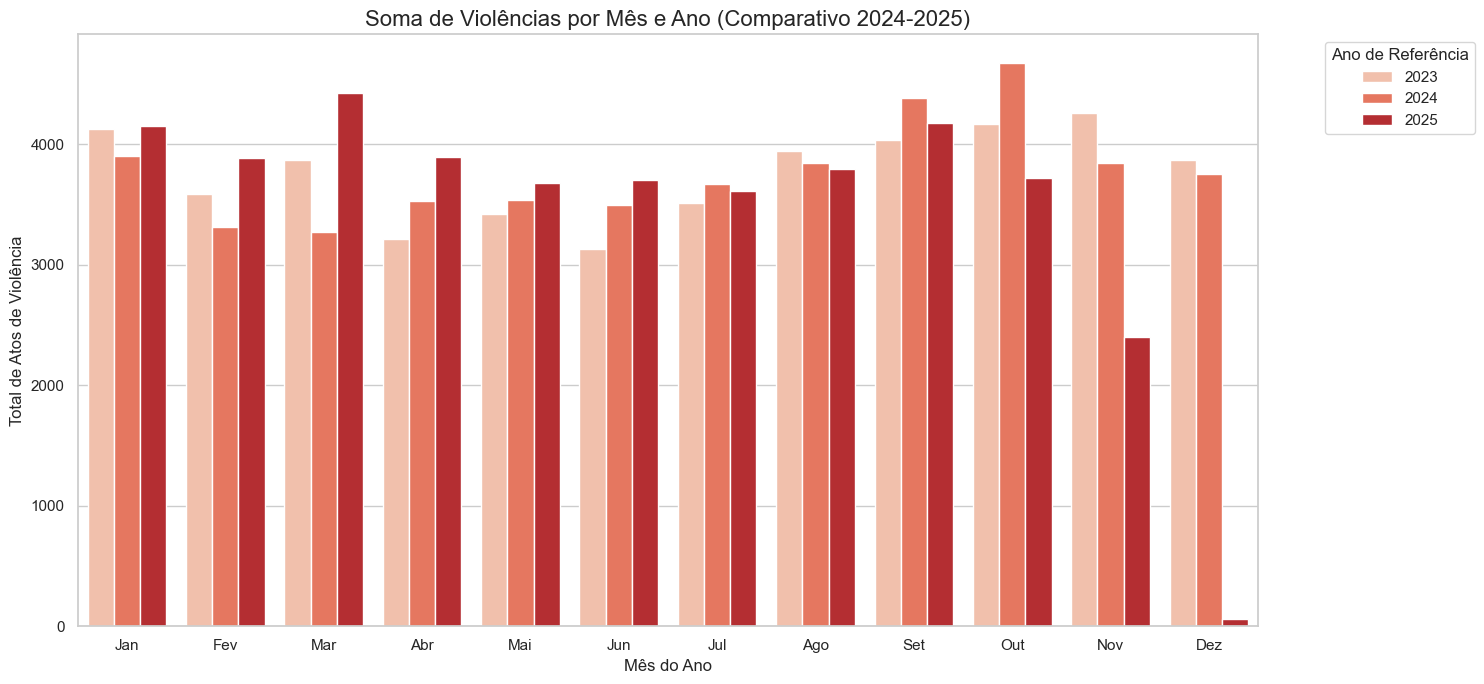

In [44]:
# -- Quinta Analise = comparativo mensal de violencias entre anos -- #
#colunas numericas de tempo
df_completo['mes_num'] = df_completo['dt_notific'].dt.month
cols_violencia = ['viol_fisic', 'viol_psico', 'viol_sexu']

#agrupando por ano e mes, somando as violencias
df_agrupado = df_completo.groupby(['ano_referencia', 'mes_num'])[cols_violencia].sum().sum(axis=1).reset_index()
df_agrupado.columns = ['Ano', 'Mes_Num', 'Total_Violencias']

#numero de meses para nomes abreviados
meses_pt = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Abr', 5:'Mai', 6:'Jun', 
            7:'Jul', 8:'Ago', 9:'Set', 10:'Out', 11:'Nov', 12:'Dez'}
df_agrupado['Mês'] = df_agrupado['Mes_Num'].map(meses_pt)

#grafico de barras agrupadas
plt.figure(figsize=(15, 7))
sns.set_style("whitegrid")

#hue separa as barras por ano dentro de cada mês
sns.barplot(data=df_agrupado, x='Mês', y='Total_Violencias', hue='Ano', palette='Reds')

plt.title('Soma de Violências por Mês e Ano (Comparativo 2024-2025)', fontsize=16)
plt.ylabel('Total de Atos de Violência')
plt.xlabel('Mês do Ano')
plt.legend(title='Ano de Referência', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()